#Markdown 2 Reportlab - Mark II

## Markdown
Here we create some lorem ipsum markdown text for testing

In [1]:
from IPython.display import HTML
import markdown as md

In [2]:
l = """LOREM ipsum dolor sit amet, _consectetur_ adipiscing elit. Praesent dignissim orci a leo dapibus semper eget sed 
sem. Pellentesque tellus nisl, condimentum nec libero id, __cursus consequat__ lectus. Ut quis nulla laoreet, efficitur 
metus sit amet, <strike>viverra dui. Nam tempor ornare urna a consequat</strike>. Nulla dolor velit, sollicitudin sit 
amet consectetur sed, interdum nec orci. Nunc suscipit tempus est ut porta. <u>Ut non felis a ligula suscipit 
posuere quis sit amet elit</u>."""

markdown_text = """
# Heading1
## Heading 2

%s %s %s


## Heading 2

%s

- %s
- %s
- %s

## Heading 2

%s

4. %s
4. %s
4. %s

%s
""" % (l,l,l,l,l,l,l,l,l,l,l,l)

In [3]:
#HTML(md.markdown(markdown_text))

## Images
here we create some images for testing

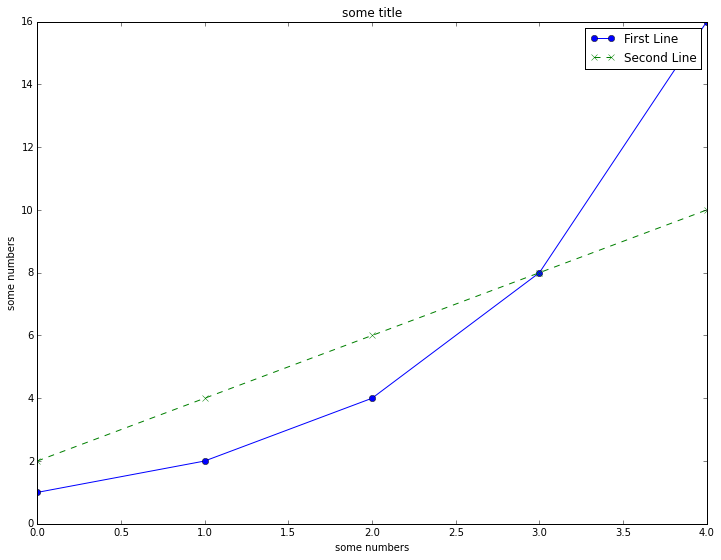

0

In [4]:
import matplotlib.pyplot as plt
from io import BytesIO

fig = plt.figure(figsize=(12, 9))
plt.plot([1,2,4,8,16], 'o-', label='First Line')
plt.plot([2,4,6,8,10], 'x--', label='Second Line')
plt.ylabel('some numbers')
plt.xlabel('some numbers')
plt.title('some title')
plt.legend()
plt.show()

fig.savefig("figure.jpeg", format='jpeg')
imgdata = BytesIO()
fig.savefig(imgdata, format='jpeg')
imgdata.seek(0)  # rewind the data

## ReportLab
import the necessary functions one by one

In [5]:
from markdown import markdown as md_markdown

from xml.etree.ElementTree import fromstring as et_fromstring
from xml.etree.ElementTree import tostring as et_tostring

from PIL import Image

#from reportlab.platypus import BaseDocTemplate as plat_BaseDocTemplate
#from reportlab.platypus import Frame as plat_Frame
#from reportlab.platypus import Paragraph as plat_Paragraph
#from reportlab.platypus import Image as plat_Image
#from reportlab.platypus import PageTemplate as plat_PageTemplate
import reportlab.platypus as plat


from reportlab.lib.styles import getSampleStyleSheet as sty_getSampleStyleSheet
from reportlab.lib.pagesizes import A4 as ps_A4
from reportlab.lib.pagesizes import A5 as ps_A5
from reportlab.lib.pagesizes import landscape as ps_landscape
from reportlab.lib.pagesizes import portrait as ps_portrait
from reportlab.lib.units import inch as un_inch

The `ReportFactory` class creates a ReportLab document / report object; the idea is that all style information as well as page layouts are collected in this object, so that when a different factory is passed to the writer object the report looks different.

In [6]:
class ReportFactory():
    """create a Reportlab report object using BaseDocTemplate
    
    the report creation is a two-step process
    
    1. instantiate a ReportFactory object
    2. retrieve the report using the report() method
    
    note: as it currently stands the report object is remembered in the
    factory object, so another call to report() return the _same_ object;
    this means that changing the paramters after report() has been called
    for the first time will not have an impact
    """
    
    def __init__(self, filename=None):      
        if filename == None: filename = 'report_x1.pdf'
        # f = open (filename,'wb') -> reports can take a file handle!
        self.filename = filename
        self.pagesize = ps_portrait(ps_A4)
        self.showboundary = 0
        #PAGE_HEIGHT=defaultPageSize[1]; PAGE_WIDTH=defaultPageSize[0]
        self.styles=sty_getSampleStyleSheet()
        self.bullet = "\u2022"
        self._report = None
 
    @staticmethod
    def static_page(canvas,doc):
        """template for report page
        
        this template defines how the standard page looks (header, footer, background
        objects; it does _not_ define the flow objects though, as those are separately
        passed to the PageTemplate() function)
        """
        canvas.saveState()
        canvas.setFont('Times-Roman',9)
        canvas.drawString(un_inch, 0.75 * un_inch, "Report - Page %d" % doc.page)
        canvas.restoreState()
    
    def refresh_styles(self):
        """refresh all styles
        
        derived ReportLab styles need to be refreshed in case the parent style
        has been modified; this does not really work though - it seems that the
        styles are simply flattened....
        """
        style_names = self.styles.__dict__['byName'].keys()
        for name in style_names:
            self.styles[name].refresh()
            
    def report(self):
        """initialise a report object
        
        this function initialised and returns a report object, based on the properties
        set on the factory object at this point (note: the report object is only generated
        _once_ and subsequent calls return the same object;this implies that most property
        changes after this function has been called are not taken into account)
        """
        if self._report == None:
            rp = plat.BaseDocTemplate(self.filename,showBoundary=self.showboundary, pagesize=self.pagesize)
            frame_page = plat.Frame(rp.leftMargin, rp.bottomMargin, rp.width, rp.height, id='main')
            pagetemplates = [
                plat.PageTemplate(id='Page',frames=frame_page,onPage=self.static_page),
            ]
            rp.addPageTemplates(pagetemplates)
            self._report = rp
        return self._report

        

The `ReportWriter` object executes the conversion from markdown to pdf. It is currently very simplistic - for example there is no entry hook for starting the conversion at the html level rather than at markdown, and only a few basic tags are implemented. 

In [7]:
class ReportWriter():
    
    def __init__(self, report_factory):
        self._simple_tags = {
            'h1'     : 'Heading1',
            'h2'     : 'Heading2',
            'h3'     : 'Heading3',
            'h4'     : 'Heading4',
            'h5'     : 'Heading5',
            'p'      : 'BodyText',
        }
        self.rf = report_factory
        self.report = report_factory.report()
        self.story = []
        
    def _render_simple_tag(self, el):
        style_name = self._simple_tags[el.tag]
        el.tag = 'para'
        text = et_tostring(el)
        self.story.append(plat.Paragraph(text,self.rf.styles[style_name]))
        
    def _render_ol(self, el):
        return self._render_error(el)
    
    def _render_ul(self, ul_el):
        for li_el in ul_el:
            li_el.tag = 'para'
            text = et_tostring(li_el)
            self.story.append(plat.Paragraph(text,self.rf.styles['Bullet'], bulletText=self.rf.bullet))
    
    def _render_error(self, el):
        self.story.append(plat.Paragraph(
            "<para fg='#ff0000' bg='#ffff00'>cannot render '%s' tag</para>" % el.tag,self.rf.styles['Normal']))
    
    @staticmethod
    def html_from_markdown(mdown, remove_newline=True, wrap=True):
        """convert markdown to html
        
        mdown - the markdown to be converted
        remove_newline - if True, all \n characters are removed after conversion
        wrap - if True, the whole html is wrapped in an <html> tag
        """
        html = md_markdown(mdown)
        if remove_newline: html = html.replace("\n", "")
        if wrap: html = "<html>"+html+"</html>"
        return html
    
    @staticmethod
    def dom_from_html(html, wrap=False):
        """convert html into a dom tree
        
        html - the html to be converted
        wrap - if True, the whole html is wrapped in an <html> tag 
        """
        if wrap: html = "<html>"+html+"</html>"
        dom = et_fromstring(html)
        return (dom)
    
    @staticmethod
    def dom_from_markdown(mdown):
        """convert markdown into a dom tree
        
        mdown - the markdown to be converted
        wrap - if True, the whole html is wrapped in an <html> tag 
        """
        html = ReportWriter.html_from_markdown(mdown, remove_newline=True, wrap=True)
        dom = ReportWriter.dom_from_html(html, wrap=False)
        return (dom)
    
    def append_from_html(self, html, wrap=True):
        """append to the story from an html text
        
        html - the html text
        wrap - whether the html must be wrapped into a single tag before rendering it into
                the DOM tree (the tag itself does not matter, but there must be one single
                root tag)
        
        Note: the html is converted into a DOM element, and then append_from_dom() is called
        """
        dom = self.dom_from_html(html, wrap)
        return self._append_from_dom(dom)
    
    def append_from_mdown(self, mdown):
        """append to the story from a markdown text
        
        mdown - the markdown text
        
        Note: the markdown is first converted into html and then into a DOM element,
        and then append_from_dom() is called
        """
        dom = self.dom_from_markdown(mdown)
        return self._append_from_dom(dom)
        
        
    def _append_from_dom(self, dom):
        """append to the story from a dom tree
        
        dom - the root element of the dom tree (note: the dom tree is modified!)
        
        Note: usually one would use append_from_mdown() or append_from_html() that in turn
        call this function here, rather than calling it directly
        """
        for el in dom:
            if el.tag in self._simple_tags:
                self._render_simple_tag(el)
            elif el.tag == 'ul':
                self._render_ul(el)
            elif el.tag == 'ol':
                self._render_ol(el)
            else:
                self._render_error(el)
        
        return self.story
    
    
    def append_from_image(self, imgfile, w=None, h=None):
        """append an image to the story
        
        imgfile - an image fileobject (including BytesIO)
        w,h - width and height of the image; both None -> page width
        
        note: ideally the image is in jpeg format
        """
        imgfile.seek(0)
        img = Image.open(imgfile)
        sx, sy = img.size
        ratio = sy/sx
        
        if w == None and h == None:
            w1 = 6*un_inch
            h1 = int(ratio * w1)
        elif h==None:
            w1 = w
            h1 = int(ratio * w)
        elif w==None:
            w1 = int(h/ratio)
            h1 = h
            
        imgfile.seek(0)
        plat_im = plat.Image(imgfile, width=w1, height=h1)
        plat_im.hAlign = 'CENTER'
        self.story.append(plat_im)
    
    
    def append_from_story(self, story):
        """append to the story from another story (or a single story element)

        story - the story array, containing the story elements (or a single story element)
        """
        if type(story) == 'list':
            self.story.extend(story)
        else:
            self.story.append(story)

    
    def finalise(self):
        """create the report, based on the story collected in the object
        """
        self.report.build(self.story)

## Create Report

create a standard report (A4, black text etc)

In [8]:
rfa4 = ReportFactory('r2port_a4.pdf')
pdfw = ReportWriter(rfa4)
pdfw.append_from_mdown(markdown_text)
pdfw.append_from_image(imgdata)
pdfw.append_from_mdown(markdown_text)
pdfw.append_from_image(imgdata, h=3*un_inch)
pdfw.append_from_mdown(markdown_text)
pdfw.append_from_image(imgdata, w=3*un_inch)
pdfw.finalise()